## Setup

### Leer datos y liberías

In [746]:

# Se cargan las librerías
from pandas import DataFrame
from pandas import concat
import random
from scipy import stats
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from pandas import DataFrame
from pandas import concat
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
from IPython.display import YouTubeVideo
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from darts import TimeSeries
import pmdarima as pm
from darts import TimeSeries
from darts.models import (NaiveSeasonal,NaiveDrift,RNNModel,Prophet,ExponentialSmoothing,ARIMA,AutoARIMA,TCNModel,TransformerModel,Theta,FFT)
import warnings
from darts.utils.utils import ModelMode, SeasonalityMode
warnings.filterwarnings('ignore')
%matplotlib inline

In [747]:
df = pd.read_excel('datos.xlsx')
df.replace(0, np.nan, inplace=True)

### Ajustes pandémicos

Agregue una simple función que traza una recta entre el inicio de la pandemia y el fin de la misma. Acá se podría mejorar la interpolación aplicando quizas una función que interpole en base a la tendencia y la estacionalidad de los periodos previos.

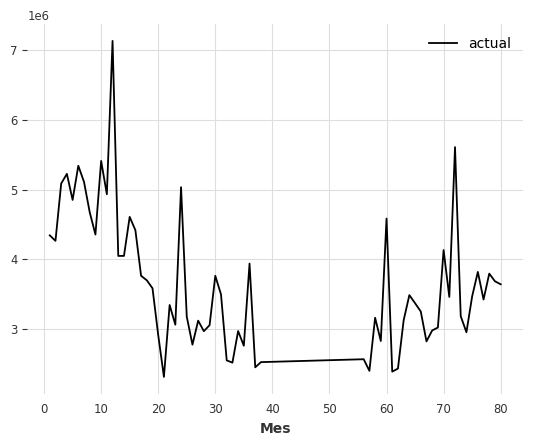

In [748]:
#OPCIÓN LINEAL

#Inicio y fin de pandemia
feb_2020_index = df[df['mes'] == '2020-02-01'].index[0]
sep_2020_index = df[df['mes'] == '2021-08-01'].index[0]
start_value = df.at[feb_2020_index, 'v_retail']
end_value = df.at[sep_2020_index, 'v_retail']

#Interpolación lineal
# Pendiente de la recta
slope = (end_value - start_value) / (sep_2020_index - feb_2020_index)

# Interpolar valores
for i in range(feb_2020_index + 1, sep_2020_index):
    df.at[i, 'v_retail'] = start_value + slope * (i - feb_2020_index)
    
# Se grafican la base completa
df['v_retail'].plot(label='actual')
plt.legend()
plt.xlabel('Mes');


In [749]:
#OPCIÓN TOMANDO SERIE PREVIA
split_date = '2020-02-01'
periods =9
prev =  df[df['mes'] <= split_date].iloc[1:]
prev = pd.DataFrame({
    'ds': prev['mes'],
    'y': prev['v_retail']
})
df_adj = pd.DataFrame({
    'ds': df['mes'],
    'y': df['v_retail']
})

In [750]:
prev_serie = TimeSeries.from_dataframe(prev, 'ds', 'y')
# Se inicializa, se entrena el modelo y se generan las predicciones
model = ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE, seasonal=SeasonalityMode.ADDITIVE,seasonal_periods=12) 
model.fit(prev_serie)
prediction = model.predict(periods)

dfs_retail = TimeSeries.from_dataframe(df_adj, 'ds', 'y')


In [751]:
# Get the time span of the shorter time series
start_short = prediction.start_time()
end_short = prediction.end_time()
# Slice the longer time series to match the time span of the shorter series
ts_long_sliced = dfs_retail.slice(start_short, end_short)
# Replace the values in the sliced longer series with the values from the shorter series
ts_long_updated = dfs_retail.drop_after(start_short).append(prediction).append(dfs_retail.drop_before(end_short))


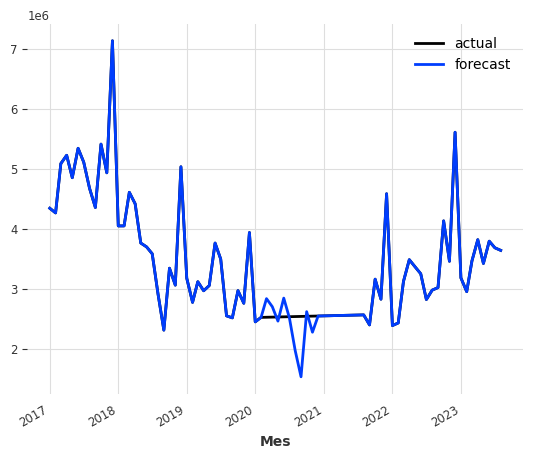

In [752]:

# Se grafican la base completa y las predicciones
dfs_retail.plot(label='actual')
ts_long_updated.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Mes');



In [753]:
#Convertir resultado a dataframe
change= ts_long_updated.pd_dataframe()

#df['v_retail'] = change['y'].values


### Preparar conjuntos de dátos

In [762]:
train = df[:int(0.85*(len(df)))].iloc[1:]
test = df[int(0.85*(len(df))):]
# Se crea la serie de tiempo de train y test para las diferentes predicciones
# tr_{columna} = dataframe de train
# ts_{columna} = dataframe de test
# df_{columna} = dataframe de df
# trs_{columna} = serie de tiempo de train
# tss_{columna} = serie de tiempo de test 
# dfs_{columna} = serie de tiempo de df

tr_retail = pd.DataFrame({
    'ds': train['mes'],
    'y': train['v_retail']
})
ts_retail = pd.DataFrame({
    'ds': test['mes'],
    'y': test['v_retail']
})
df_retail = pd.DataFrame({
    'ds': df['mes'],
    'y': df['v_retail']
})

trs_retail = TimeSeries.from_dataframe(tr_retail, 'ds', 'y')
tss_retail = TimeSeries.from_dataframe(ts_retail, 'ds', 'y')
dfs_retail = TimeSeries.from_dataframe(df_retail, 'ds', 'y')

## Modelos

### Suavizado exponencial

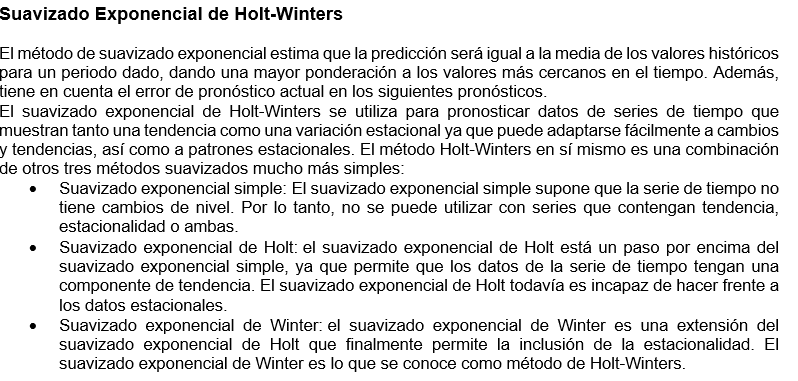

#### Suavizado exponencial simple

In [763]:

resultados = pd.DataFrame()

Test RMSE: 1092712.346
Test MSE: 1194020272008.921
Test MAE: 865003.345
Test R2: -1.694


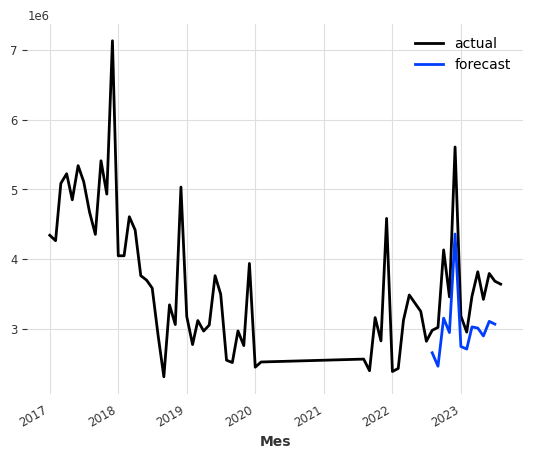

In [764]:

# Se inicializa, se entrena el modelo y se generan las predicciones
model = ExponentialSmoothing()
model.fit(trs_retail)
prediction = model.predict(test.shape[0])
# calculate RMSE
rmse = sqrt(mean_squared_error(ts_retail['y'], prediction.pd_dataframe()))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MAE: %.3f' % mae)
r2 = r2_score(ts_retail['y'], prediction.pd_dataframe())
print('Test R2: %.3f' % r2)
row = pd.DataFrame([{'Modelo':'EXS: Simple','RMSE':rmse,'MSE':mse,'MAE':mae,'R2':r2}])
resultados =pd.concat([resultados,row],axis=0)


# Se grafican la base completa y las predicciones
dfs_retail.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Mes');

# Get the time span of the shorter time series
#start_short = prediction.start_time()
#end_short = prediction.end_time()
# Slice the longer time series to match the time span of the shorter series
#ts_long_sliced = dfs_retail.slice(dfs_retail.start_time(), prediction.start_time())
# Replace the values in the sliced longer series with the values from the shorter series
#ts_long_updated = dfs_retail.drop_after(start_short).append(prediction)

# Se grafican la base completa y las predicciones
#dfs_retail.plot(label='actual')
#ts_long_updated.plot(label='forecast', lw=2)
#plt.legend()
#plt.xlabel('Mes');

#### Suavizado Exponencial de Holt

Test RMSE: 701625.898
Test MSE: 492278900665.989
Test MAE: 643367.713
Test R2: -0.108


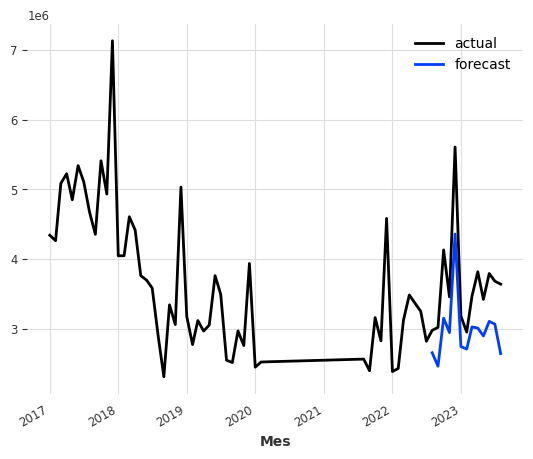

In [757]:

# Se inicializa, se entrena el modelo y se generan las predicciones
model = ExponentialSmoothing(trend=ModelMode.ADDITIVE) 
model.fit(trs_retail)
prediction = model.predict(test.shape[0])
# calculate RMSE
rmse = sqrt(mean_squared_error(ts_retail['y'], prediction.pd_dataframe()))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MAE: %.3f' % mae)
r2 = r2_score(ts_retail['y'], prediction.pd_dataframe())
print('Test R2: %.3f' % r2)
row = pd.DataFrame([{'Modelo':'EXS: Holt (Add)','RMSE':rmse,'MSE':mse,'MAE':mae,'R2':r2}])
resultados =pd.concat([resultados,row],axis=0)
# Se grafican la base completa y las predicciones
dfs_retail.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Mes');

Test RMSE: 1156157.616
Test MSE: 1336700432360.966
Test MAE: 953030.485
Test R2: -2.016


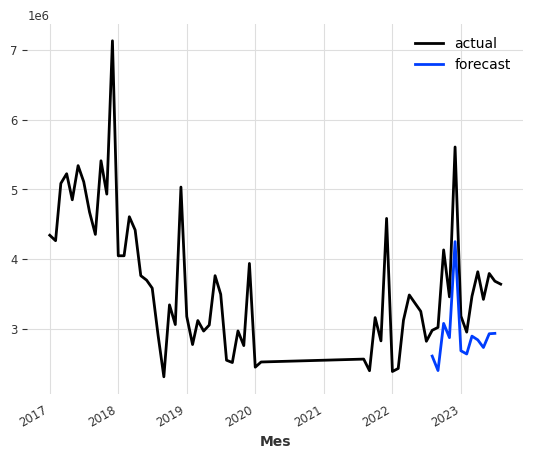

In [765]:

# Se inicializa, se entrena el modelo y se generan las predicciones
model = ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE) 
model.fit(trs_retail)
prediction = model.predict(test.shape[0])
# calculate RMSE
rmse = sqrt(mean_squared_error(ts_retail['y'], prediction.pd_dataframe()))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MAE: %.3f' % mae)
r2 = r2_score(ts_retail['y'], prediction.pd_dataframe())
print('Test R2: %.3f' % r2)
row = pd.DataFrame([{'Modelo':'EXS: Holt (Mult)','RMSE':rmse,'MSE':mse,'MAE':mae,'R2':r2}])
resultados =pd.concat([resultados,row],axis=0)
# Se grafican la base completa y las predicciones
dfs_retail.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Mes');

Aca me pregunto si no tiene sentido ajustar el modelo por una constante. No veo que haya un tuning que se le pueda hacer fácil, pero si a las predicciones las movemos para arriba por una constante la forma es bastante correcta

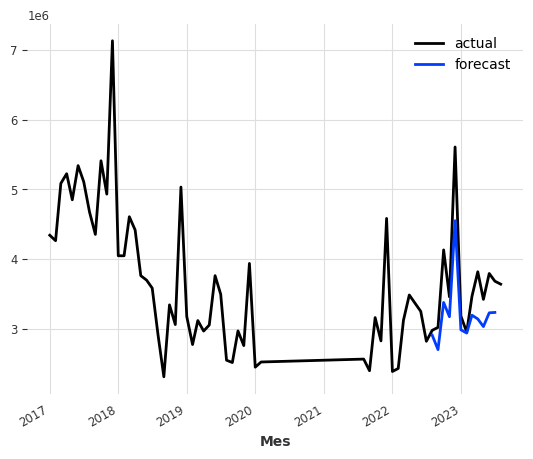

In [766]:
#Ajuste por constante
number_to_add = 300000
prediction = prediction.map(lambda x: x + number_to_add)


# Se grafican la base completa y las predicciones
dfs_retail.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Mes');

#### Suavizado de Winter

Test RMSE: 1120421.424
Test MSE: 1255344167408.041
Test MAE: 1081230.800
Test R2: -1.826


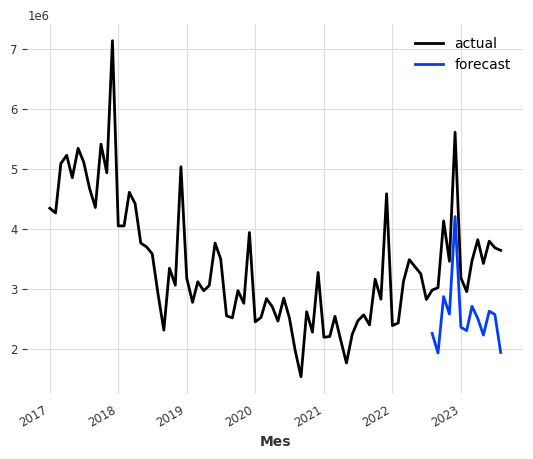

In [728]:

# Se inicializa, se entrena el modelo y se generan las predicciones
model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE,seasonal_periods=12) 
model.fit(trs_retail)
prediction = model.predict(test.shape[0])
# calculate RMSE
rmse = sqrt(mean_squared_error(ts_retail['y'], prediction.pd_dataframe()))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MAE: %.3f' % mae)
r2 = r2_score(ts_retail['y'], prediction.pd_dataframe())
print('Test R2: %.3f' % r2)
row = pd.DataFrame([{'Modelo':'EXS: Winter (Add,Add)','RMSE':rmse,'MSE':mse,'MAE':mae,'R2':r2}])
resultados =pd.concat([resultados,row],axis=0)
# Se grafican la base completa y las predicciones
dfs_retail.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Mes');

Test RMSE: 1289583.043
Test MSE: 1663024425709.688
Test MAE: 1246086.890
Test R2: -2.744


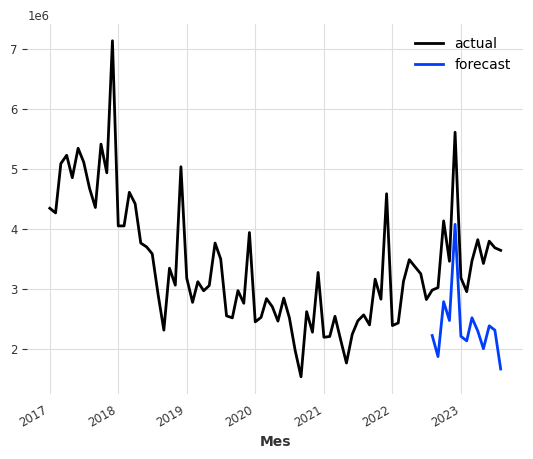

In [729]:

# Se inicializa, se entrena el modelo y se generan las predicciones
model = ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE, seasonal=SeasonalityMode.ADDITIVE,seasonal_periods=12) 
model.fit(trs_retail)
prediction = model.predict(test.shape[0])
# calculate RMSE
rmse = sqrt(mean_squared_error(ts_retail['y'], prediction.pd_dataframe()))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MAE: %.3f' % mae)
r2 = r2_score(ts_retail['y'], prediction.pd_dataframe())
print('Test R2: %.3f' % r2)
row = pd.DataFrame([{'Modelo':'EXS: Winter (Mult,Add)','RMSE':rmse,'MSE':mse,'MAE':mae,'R2':r2}])
resultados =pd.concat([resultados,row],axis=0)
# Se grafican la base completa y las predicciones
dfs_retail.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Mes');

Test RMSE: 1338888.724
Test MSE: 1792623015232.029
Test MAE: 1283497.506
Test R2: -3.036


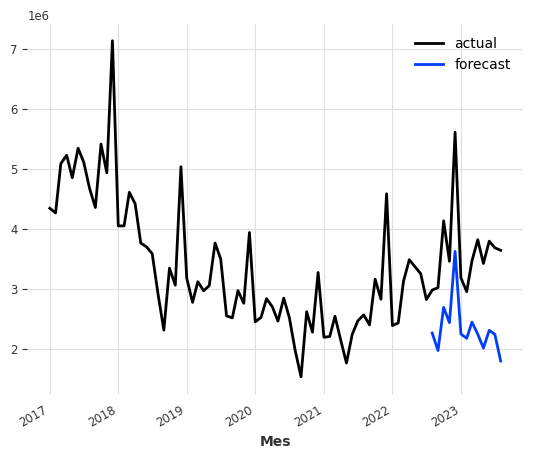

In [730]:

# Se inicializa, se entrena el modelo y se generan las predicciones
model = ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE, seasonal=SeasonalityMode.MULTIPLICATIVE,seasonal_periods=12) 
model.fit(trs_retail)
prediction = model.predict(test.shape[0])
# calculate RMSE
rmse = sqrt(mean_squared_error(ts_retail['y'], prediction.pd_dataframe()))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MAE: %.3f' % mae)
r2 = r2_score(ts_retail['y'], prediction.pd_dataframe())
print('Test R2: %.3f' % r2)
row = pd.DataFrame([{'Modelo':'EXS: Winter (Mult,Mult)','RMSE':rmse,'MSE':mse,'MAE':mae,'R2':r2}])
resultados =pd.concat([resultados,row],axis=0)
# Se grafican la base completa y las predicciones
dfs_retail.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Mes');

In [731]:
resultados

,Modelo,RMSE,MSE,MAE,R2
0,EXS: Simple,1.120421e+06,1.255344e+12,1.081231e+06,-1.826430
0,EXS: Holt (Add),1.120421e+06,1.255344e+12,1.081231e+06,-1.826430
0,EXS: Holt (Mult),1.289583e+06,1.663024e+12,1.246087e+06,-2.744329
0,"EXS: Winter (Add,Add)",1.120421e+06,1.255344e+12,1.081231e+06,-1.826430
0,"EXS: Winter (Mult,Add)",1.289583e+06,1.663024e+12,1.246087e+06,-2.744329
0,"EXS: Winter (Mult,Mult)",1.338889e+06,1.792623e+12,1.283498e+06,-3.036123


### AutoARIMA

Test RMSE: 902949.887
Test MSE: 815318497710.869
Test MAE: 625319.867
Test R2: -0.836


Text(0.5, 0, 'Mes')

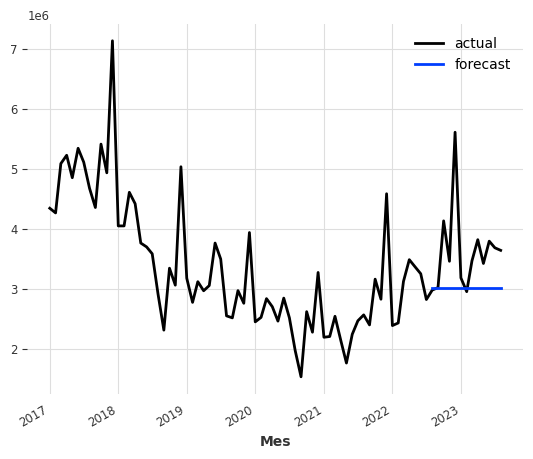

In [732]:
# Se inicializa, se entrena el modelo y se generan las predicciones
model_aarima = AutoARIMA(random_state = 10)
model_aarima.fit(trs_retail)
prediction = model_aarima.predict(len(tss_retail))
# calculate RMSE
rmse = sqrt(mean_squared_error(ts_retail['y'], prediction.pd_dataframe()))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MAE: %.3f' % mae)
r2 = r2_score(ts_retail['y'], prediction.pd_dataframe())
print('Test R2: %.3f' % r2)
row = pd.DataFrame([{'Modelo':'AutoARIMA','RMSE':rmse,'MSE':mse,'MAE':mae,'R2':r2}])
resultados =pd.concat([resultados,row],axis=0)
# Se grafican la base completa y las predicciones
dfs_retail.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Mes')

### **RNN (LSTM)**

In [733]:
# Se normaliza la base
from darts.dataprocessing.transformers import Scaler
transformer = Scaler()
train_transformed = transformer.fit_transform(trs_retail)
test_transformed = transformer.transform(tss_retail)
series_transformed = transformer.transform(dfs_retail)

In [734]:
# Se inicializa, se entrena el modelo y se generan las predicciones
model_RNN = RNNModel( model='LSTM',
    input_chunk_length=10,
    output_chunk_length=1,
    hidden_dim=25,
    n_rnn_layers=2,
    dropout=0.2,
    batch_size=32,
    n_epochs=100,
    optimizer_kwargs={'lr': 1e-3},
    log_tensorboard=True,
    random_state=42)
model_RNN.fit(train_transformed)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 8.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 50.77it/s, v_num=logs, train_loss=0.0214]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 48.09it/s, v_num=logs, train_loss=0.0214]


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=2, dropout=0.2, training_length=24, input_chunk_length=10, output_chunk_length=1, batch_size=32, n_epochs=100, optimizer_kwargs={'lr': 0.001}, log_tensorboard=True, random_state=42)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.96it/s]
Test RMSE: 3689922.585
Test MSE: 13615528684935.514
Test MAE: 3629240.123
Test R2: -29.656


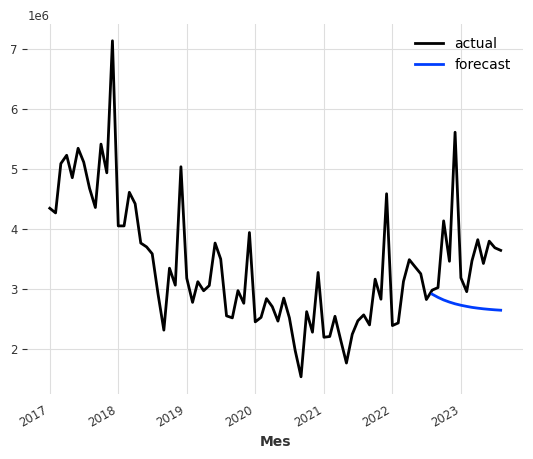

In [735]:
prediction = model_RNN.predict(len(test_transformed))
transformer.inverse_transform(prediction)

# Cálculo de las medidas de precisión
rmse = sqrt(mean_squared_error(ts_retail['y'], prediction.pd_dataframe()))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MAE: %.3f' % mae)
r2 = r2_score(ts_retail['y'], prediction.pd_dataframe())
print('Test R2: %.3f' % r2)

row = pd.DataFrame([{'Modelo':'RNN (LSTM)','RMSE':rmse,'MSE':mse,'MAE':mae,'R2':r2}])
resultados =pd.concat([resultados,row],axis=0)
# Se grafican la base completa y las predicciones
transformer.inverse_transform(series_transformed).plot(label='actual')
transformer.inverse_transform(prediction).plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Mes');


### **FFT (Fast Fourier Transform)**

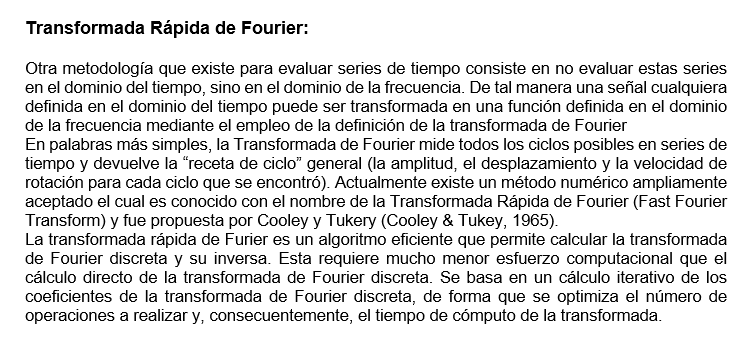

Test RMSE: 1384437.943
Test MSE: 1916668417401.570
Test MAE: 1283452.657
Test R2: -3.315


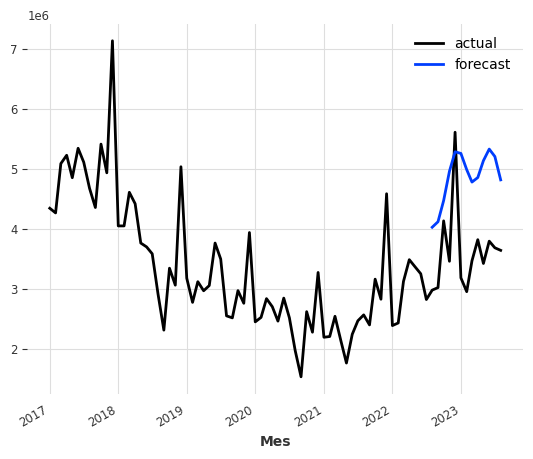

In [736]:
# Se inicializa, se entrena el modelo y se generan las predicciones
model = FFT()
model.fit(trs_retail)
prediction = model.predict(test.shape[0])
# calculate RMSE
rmse = sqrt(mean_squared_error(ts_retail['y'], prediction.pd_dataframe()))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(ts_retail['y'], prediction.pd_dataframe())
print('Test MAE: %.3f' % mae)
r2 = r2_score(ts_retail['y'], prediction.pd_dataframe())
print('Test R2: %.3f' % r2)
row = pd.DataFrame([{'Modelo':'Fast Fourier Transform (FFT)','RMSE':rmse,'MSE':mse,'MAE':mae,'R2':r2}])
resultados =pd.concat([resultados,row],axis=0)
# Se grafican la base completa y las predicciones
dfs_retail.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Mes');

In [737]:
resultados

,Modelo,RMSE,MSE,MAE,R2
0,EXS: Simple,1.120421e+06,1.255344e+12,1.081231e+06,-1.826430
0,EXS: Holt (Add),1.120421e+06,1.255344e+12,1.081231e+06,-1.826430
0,EXS: Holt (Mult),1.289583e+06,1.663024e+12,1.246087e+06,-2.744329
0,"EXS: Winter (Add,Add)",1.120421e+06,1.255344e+12,1.081231e+06,-1.826430
0,"EXS: Winter (Mult,Add)",1.289583e+06,1.663024e+12,1.246087e+06,-2.744329
0,"EXS: Winter (Mult,Mult)",1.338889e+06,1.792623e+12,1.283498e+06,-3.036123
0,AutoARIMA,9.029499e+05,8.153185e+11,6.253199e+05,-0.835704
0,RNN (LSTM),3.689923e+06,1.361553e+13,3.629240e+06,-29.655607
0,Fast Fourier Transform (FFT),1.384438e+06,1.916668e+12,1.283453e+06,-3.315413
